In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# setup
- seed
- TensorBoard
- config

In [2]:
from dataclasses import dataclass

@dataclass
class Config:
    seed = 111
    batch_size: int = 256
    dataset_size: int = -1
    start_epoch: int = 0
    n_epochs: int = 1000
    lr: float = 0.0001

    relu_slope: float = 0.2
    dropout: float = 0.5
    # randn dim
    # in_dim: int = 100
    in_dim: int = 10
    # 3 channels, 218x178
    # out_dim: int = 3 * 218 * 178
    out_dim: int = 1 * 28 * 28

    save_epoch_interval: int = 30
    exp_id: str = 'mnist_gan_exp_0616_1'

config = Config()

In [3]:
import random

random.seed((config.seed))
torch.manual_seed(config.seed)

In [4]:
from torch.utils.tensorboard import SummaryWriter
import datetime

def setup_tensorboard(id):
    # template = "%Y-%m-%d_%H-%M-%S"
    print(f'logdir=runs/{id}')
    writer = SummaryWriter(f'runs/{id}')
    return writer

writer = setup_tensorboard(config.exp_id)

logdir=runs/mnist_gan_exp_0616_1


## Dataset


In [5]:
def clean_cache():
    # empty cache
    torch.cuda.empty_cache()
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |    2058 KB |    2649 KB |    2649 KB |
|       from large pool |       0 B  |       0 KB |       0 KB |       0 KB |
|       from small pool |       0 B  |    2058 KB |    2649 KB |    2649 KB |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |    2058 KB |    2649 KB |    2649 KB |
|       from large pool |       0 B  |       0 KB |       0 KB |

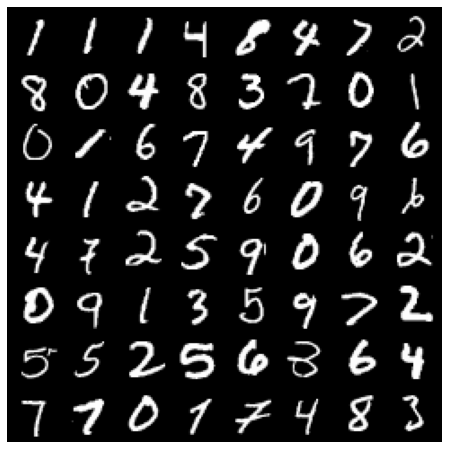

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

data = datasets.MNIST(root='./dataset', download=True, transform=transform)
# <https://stackoverflow.com/questions/70896841/error-downloading-celeba-dataset-using-torchvision>
# data = datasets.CelebA(root='./dataset', download=True, transform=transform)

# load dataset partially
if config.dataset_size > 0:
    data, _ = random_split(data, [config.dataset_size, len(data) - config.dataset_size])

dataloader = DataLoader(data, batch_size=config.batch_size, shuffle=True, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def preview_dataset(dataloader):
    batch = next(iter(dataloader))
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(np.transpose(
        vutils.make_grid(
            batch[0].to(device)[:64], 
            padding=2, 
            normalize=True
        ).cpu(), (1,2,0))
    )

preview_dataset(dataloader)
clean_cache()
print(f'data={len(dataloader) * config.batch_size}, batch_size={config.batch_size}, n_epochs={config.n_epochs}')


# Model

In [7]:
class Generator(nn.Module):
    def __init__(self, config: Config):
        super(Generator, self).__init__()
        sizes = [config.in_dim, 256, 512, 1024, config.out_dim]
        self.slope = config.relu_slope

        self.net = nn.Sequential(
            nn.Linear(sizes[0], sizes[1]),
            nn.LeakyReLU(config.relu_slope, inplace=True),

            nn.Linear(sizes[1], sizes[2]),
            nn.LeakyReLU(config.relu_slope, inplace=True),

            nn.Linear(sizes[2], sizes[3]),
            nn.LeakyReLU(config.relu_slope, inplace=True),

            nn.Linear(sizes[3], sizes[4]),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, config: Config):
        super(Discriminator, self).__init__()
        sizes = [config.out_dim, 1024, 512, 256, 1]
        self.net = nn.Sequential(
            nn.Linear(sizes[0], sizes[1]),
            nn.LeakyReLU(config.relu_slope, inplace=True),
            nn.Dropout(config.dropout),

            nn.Linear(sizes[1], sizes[2]),
            nn.LeakyReLU(config.relu_slope, inplace=True),
            nn.Dropout(config.dropout),

            nn.Linear(sizes[2], sizes[3]),
            nn.LeakyReLU(config.relu_slope, inplace=True),
            nn.Dropout(config.dropout),

            nn.Linear(sizes[3], sizes[4]),
            nn.Dropout(config.dropout),
            nn.Sigmoid(),
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

# Train

In [8]:
def save_checkpoint(generator: Generator, discriminator: Discriminator, optim_generator, optim_discriminator, config: Config, epoch: int):
    print(f'save models @ epoch={epoch}')
    torch.save({
        'epoch': epoch,
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict(),
        'optim_generator': optim_generator.state_dict(),
        'optim_discriminator': optim_discriminator.state_dict(),
    }, f'models/{config.exp_id}_{epoch}.pt')


def load_checkpoint(config: Config, start_epoch: int):
    print(f'load models @ epoch={start_epoch}')
    checkpoint = torch.load(f'models/{config.exp_id}_{start_epoch}.pt')

    config.start_epoch = checkpoint['epoch'] + 1
    generator = Generator(config).to(device)
    generator.load_state_dict(checkpoint['generator'])
    generator.train()
    discriminator = Discriminator(config).to(device)
    discriminator.load_state_dict(checkpoint['discriminator'])
    discriminator.train()

    optim_generator = optim.AdamW(generator.parameters(), lr=config.lr)
    optim_generator.load_state_dict(checkpoint['optim_generator'])
    optim_discriminator = optim.Adam(discriminator.parameters(), lr=config.lr)
    optim_discriminator.load_state_dict(checkpoint['optim_discriminator'])
    
    return generator, discriminator, optim_generator, optim_discriminator


def create_model(config: Config):
    """
    create new model etc
    """
    generator = Generator(config).to(device)
    discriminator = Discriminator(config).to(device)

    optim_generator = optim.AdamW(generator.parameters(), lr=config.lr)
    optim_discriminator = optim.AdamW(discriminator.parameters(), lr=config.lr)

    return generator, discriminator, optim_generator, optim_discriminator

def train(
    writer: SummaryWriter,
    generator: Generator, 
    discriminator: Discriminator,
    optim_generator,
    optim_discriminator,
    dataloader: DataLoader,
    config: Config,
):
    criterion = nn.BCELoss()
    print(f'criterion: {criterion}')
    for epoch in range(config.start_epoch, config.start_epoch + config.n_epochs):
        now = datetime.datetime.now
        print(f'[{now()}] Epoch {epoch}')
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device).view(-1, config.out_dim)
            step = epoch * len(dataloader) + i
            z = torch.randn(config.batch_size, config.in_dim, device = device)

            # train generator
            fake = generator(z)
            fake_output = discriminator(fake)

            loss_generator = criterion(fake_output, torch.ones_like(fake_output))

            optim_generator.zero_grad()
            loss_generator.backward()
            optim_generator.step()

            # train discriminator
            z = torch.randn(config.batch_size, config.in_dim, device = device)
            real_output = discriminator(x)
            fake_output = discriminator(generator(z))
            loss_real = criterion(real_output, torch.ones_like(real_output))
            loss_fake = criterion(fake_output, torch.zeros_like(fake_output))

            loss_discriminator = (loss_real + loss_fake) / 2.

            optim_discriminator.zero_grad()
            loss_discriminator.backward()
            optim_discriminator.step()

            writer.add_scalar('loss/generator', loss_generator.item(), step)
            writer.add_scalar('loss/discriminator', loss_discriminator.item(), step)
            print(f'[{now()}] Epoch {epoch} batch {i} loss/g: {loss_generator.item():.2f} loss/d: {loss_discriminator.item():.2f}')

        # generate image
        with torch.no_grad():
            # input
            z = torch.randn(config.batch_size, config.in_dim).to(device)
            images = generator(z).view(-1, *shape)
            writer.add_images(f'generated_image', images, epoch)

        if epoch % config.save_epoch_interval == 0:
            save_checkpoint(generator, discriminator, optim_generator, optim_discriminator, config, epoch)

In [9]:
clean_cache()

# (channel, width, height)
shape = iter(dataloader).next()[0].shape[1:]
# generator, discriminator, optim_generator, optim_discriminator = load_model(config, 0)
generator, discriminator, optim_generator, optim_discriminator = create_model(config)
train(writer, generator, discriminator, optim_generator, optim_discriminator, dataloader, config)

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |    2058 KB |    2649 KB |    2649 KB |
|       from large pool |       0 B  |       0 KB |       0 KB |       0 KB |
|       from small pool |       0 B  |    2058 KB |    2649 KB |    2649 KB |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |    2058 KB |    2649 KB |    2649 KB |
|       from large pool |       0 B  |       0 KB |       0 KB |

# Test

In [ ]:
generator, _, _ , _ = load_model(config, 0)
generator.eval()

z = torch.randn(config.batch_size, config.in_dim).to(device)
images = generator(z).view(-1, *shape)

print(images)